# Historical Extreme Events from 1950 - 2014 using various Standardized Precipitation Indices (SPIs) 

In [2]:
import pandas as pd
import xarray as xr
import zipfile
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sc
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline

path = os.getcwd()

In [3]:
models = ['access_cm2','bcc_csm2_mr','cesm2','cmcc_esm2','cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr','fgoals_g3',
          'gfdl_esm4','hadgem3_gc31_ll','iitm_esm','inm_cm4_8','inm_cm5_0','ipsl_cm5a2_inca','ipsl_cm6a_lr','kace_1_0_g', 
          'miroc6','mpi_esm1_2_lr','miroc_es2l','mri_esm2_0','noresm2_mm','taiesm1','ukesm1_0_ll']
#'sam0_unicon',
models = sorted(models)


In [9]:
#unzip function
def unzip(z_file, model, print_info=True):
    with zipfile.ZipFile(z_file, 'r') as zip_ref:
        zip_ref.extractall(model)
        if print_info==True:
            print('Done with '+model+' model')
            
            
#Standardized Precipitation Index Function for 3D
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)
    
    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF) 
    gamma_func = lambda data, a, scale: sc.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: sc.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi


def filtercounter(ds, x, y):
    return ds.where((ds > x) & (ds <= y)).count().values.tolist()

def filtermean(ds, x, y):
    return ds.where((ds > x) & (ds <= y)).reduce(np.nanmean).values.tolist()


def count_avg(ws):
    grouped_da_RAI = ws
    for class_name in classification:
        if (class_name == 'Extremely Dry'):
            n = grouped_da_RAI.where((grouped_da_RAI <= -3)).count().values.tolist()
            n2 = grouped_da_RAI.where((grouped_da_RAI <= -3)).reduce(np.nanmean).values.tolist()
            count_val.append(n)
            avg_val.append(n2)

        elif( class_name == 'Very Dry'):
            n = filtercounter(grouped_da_RAI,-3,-2)
            n2 = filtermean(grouped_da_RAI,-3,-2)
            count_val.append(n)
            avg_val.append(n2)

        elif(class_name == 'Dry'):
            n = filtercounter(grouped_da_RAI,-2,-1)
            n2 = filtermean(grouped_da_RAI,-2,-1)
            count_val.append(n)
            avg_val.append(n2)

        elif(class_name == 'Normal'):
            n = grouped_da_RAI.where((grouped_da_RAI >-1) & (grouped_da_RAI< 1)).count().values.tolist()
            count_val.append(n)
            n2 = grouped_da_RAI.where((grouped_da_RAI > -1) & (grouped_da_RAI< 1)).reduce(np.nanmean).values.tolist()
            avg_val.append(n2)

        elif(class_name == 'Humid'):
            n = filtercounter(grouped_da_RAI,1,2)
            count_val.append(n)
            n2 = filtermean(grouped_da_RAI,1,2)
            avg_val.append(n2)

        elif(class_name == 'Very Humid'):
            n = filtercounter(grouped_da_RAI,2,3)
            count_val.append(n)
            n2 = filtermean(grouped_da_RAI,2,3)
            avg_val.append(n2)

        else:
            n =grouped_da_RAI.where((grouped_da_RAI >= 3)).count().values.tolist()
            count_val.append(n)
            n2 = grouped_da_RAI.where((grouped_da_RAI >= 3)).reduce(np.nanmean).values.tolist()
            avg_val.append(n2)


    final_count[zone] = count_val
    f_count = pd.DataFrame(final_count).T
    f_count.columns=classification
    final_avg[zone] = avg_val
    f_avg = pd.DataFrame(final_avg).T
    f_avg.columns=classification
    return f_count, f_avg 


def background(ax,x):
    dx = 20
    theta = np.linspace(0,np.pi,100)#*100
    r = np.sin(theta)*(100-dx)

    #ax = plt.subplot(2,2,(o+1), polar=True)
    #ax = x.plot(polar=True)
    c = ax.scatter(theta, r, c=r, s=20, cmap='Blues', alpha=0.0)

    ax.set_thetamin(0)
    ax.set_thetamax(180)

    ax.set_yticks(np.arange(0,60.1,10),)#np.arange(-50,100.1,10))
    ax.text( -0.35, 40, 'Events (%)', color='k', fontsize = 15)
    ax.set_xticks(np.arange(0,np.pi+0.1,np.pi/8))

    perc = ['< -3', '-3', '-2', '-1', '', '1', '2', '3', '> 3']
    ax.set_xticklabels(perc[::-1])
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    #Descriptors
    ax.text( 1.65, 116-dx, 'Normal', color='r', fontsize = 15)
    ax.text( 2.2, 117-dx, 'Dry', color='r', fontsize = 14, rotation=35)
    ax.text( 2.65, 117-dx, 'Very Dry', color='r', fontsize = 14, rotation=60)
    ax.text( 3.075, 120-dx, "Extremely\n Dry", color='r', fontsize = 14, rotation=82.5)

    ax.text( 1, 114-dx, 'Wet', color='r', fontsize = 14, rotation=-35)
    ax.text( 0.57, 108-dx, 'Very Wet', color='r', fontsize = 14, rotation=-60)
    ax.text( 0.03, 108-dx, "Extremely\n Wet", color='r', fontsize = 14, rotation=-82.5)


    ax.tick_params(axis='both', labelsize=12)
    ax.spines['inner'].set_color('r')
    ax.spines['polar'].set_linewidth(2)
    #ax.spines['end'].set_linewidth(0)

    ax.grid(True, which='major', axis='both', linestyle='--', color = 'b', linewidth=1)
    ax.get_xgridlines()[4].set_linestyle('None')
    ax.get_xgridlines()[-1].set_linestyle('None')
    ax.set_title(x, fontsize = 15)
    colors=['r']

    return ax



def pointers(ax, num, percentage, linestyle = None, color = None, marker=None, marksize=None, label=None, show_legend=None):
    b=num
    pos=np.int_(b)+(np.ones(len(b))*4)
    #pos = int(b)+4  #position of the whole number component of the number within the perc array.
    perc = ['< -3', '-3', '-2', '-1', '', '1', '2', '3', '> 3']
    whole = (((pos)/(len(perc)-1))*np.pi)       #change whole part to angle
    bot = np.ones(len(b))*(len(perc)-1)
    bot1 = np.ones(len(b))*np.pi
    frac = ((b-np.int_(b))/bot)*bot1    #change fractional part to angle

    if color == None:
        ax.plot(np.pi-whole-frac,percentage,linestyle=linestyle, linewidth=2, marker = marker, markersize=marksize, label=label)
    else:
        ax.plot(np.pi-whole-frac,percentage,linestyle=linestyle, color=color, linewidth=5, marker = marker, markersize=marksize, label=label)
   
    #ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.25, 1))

    if show_legend==True:
        ax.legend(loc=0, ncol=2, bbox_to_anchor=(2.6, 0.8), fontsize=14)
    #else:
    #    ax.legend(loc=0, ncol=10, bbox_to_anchor=(1.25, 1), alpha=0.0)

    

def save_plot(path, filename):
    import matplotlib.pyplot as plt
    if os.path.isdir(path) == False:
        os.mkdir(path)
        
    plt.savefig(path+'/'+filename)

In [5]:
'''
#sampled_da['spi_3'].sel(time='2010').plot(cmap='RdBu', col='time', col_wrap=4, vmin=-2.5, vmax=2.5)
sampled_da.spi_3.sel(time='2010').plot()
plt.ylim(0,15)
plt.xlim(-20,15)
'''

"\n#sampled_da['spi_3'].sel(time='2010').plot(cmap='RdBu', col='time', col_wrap=4, vmin=-2.5, vmax=2.5)\nsampled_da.spi_3.sel(time='2010').plot()\nplt.ylim(0,15)\nplt.xlim(-20,15)\n"

###  SPI-1 Polar plots of extreme events of precipitation for the ecological zones over West Africa

0
            Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
access_cm2              0        17  174     783    165          28   

            Extremely Wet  
access_cm2              3  
            Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
access_cm2              2        24   90     530    122          12   

            Extremely Wet  
access_cm2              0  
1
             Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
bcc_csm2_mr              0        17  258    1189    229          59   

             Extremely Wet  
bcc_csm2_mr              3  
             Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
bcc_csm2_mr              0        23  167     790    164          25   

             Extremely Wet  
bcc_csm2_mr              1  
2
       Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  Extremely Wet
cesm2             11        30  320    1625    274          79              1
       Extremely Dry  Very Dry  Dr

21
         Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
taiesm1              4        86  301    1606    323          20   

         Extremely Wet  
taiesm1              0  
         Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
taiesm1              0        24  240    1244    178          51   

         Extremely Wet  
taiesm1             18  
22
             Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
ukesm1_0_ll              3        25  154     800    160          25   

             Extremely Wet  
ukesm1_0_ll              3  
             Extremely Dry  Very Dry  Dry  Normal  Humid  Very Humid  \
ukesm1_0_ll              0        22   99     543     95          20   

             Extremely Wet  
ukesm1_0_ll              1  


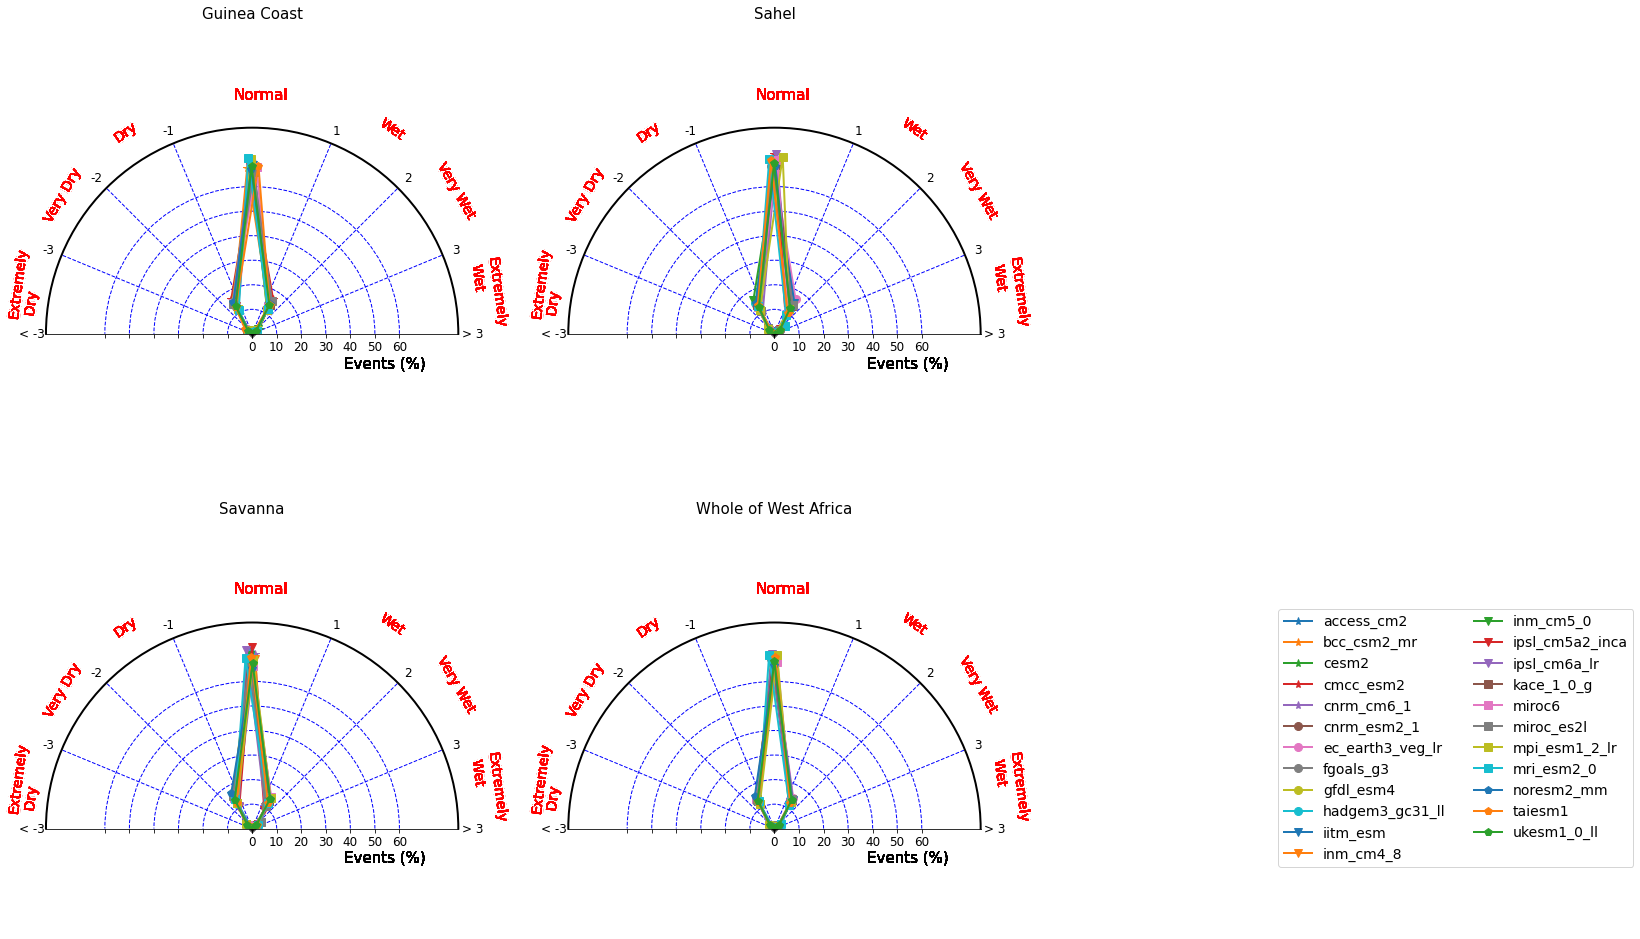

In [21]:
exp='historical'
ystart=1950; yend=2014
classification = ['Extremely Dry', 'Very Dry', 'Dry','Normal', 'Humid', 'Very Humid', 'Extremely Wet']

#plt.figure(figsize = (14,14))

#plt.subplots_adjust(hspace=0.5) 
fig,axes = plt.subplots(2,2,figsize = (14,14),subplot_kw=dict(polar=True))
#plt.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.9, left=0,right=0.95, bottom=0) 
ax = axes.flatten()
zones = ['Guinea Coast','Sahel','Savanna','Whole of West Africa']
for i, mod in enumerate(models):
    file = glob.glob(os.path.join(path,exp+'/*'+mod+'*.zip'))[0]
    data_file = glob.glob(os.path.join(path,mod+'/pr*'+exp+'*.nc'))[0]
    da_data = xr.open_dataset(data_file)
    print(i)
    #percentages={}
    for j,zone in enumerate(zones):
        n_thresh = 1
        a = background(ax[j],zone)
        final_count = {}
        final_avg = {}
        count_val = []
        avg_val = []

        if zone == 'Guinea Coast':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(4,8), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_1 = spi(sampled_da, n_thresh,'time')[9]
            
            C,AV = count_avg(spi_1)
            print(C)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            #print(AV)
            #if i ==
            #e_mean = sampled_da
            
        elif zone == 'Sahel':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(12,20), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_1 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_1)
            print(C)
            per = (C/max(C.sum(axis = 1)))*100
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            
            
        elif zone == 'Savanna':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(8,12), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_1 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_1)
            per = (C/max(C.sum(axis = 1)))*100
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            
            
        else:
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(4,20), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_1 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_1)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=True)
#fig.delaxes(ax[4])           
   
save_plot('/home/receiver/Desktop/Data/plots/','SPI-1_Polar_plot_extreme_events')

###  SPI-3 Polar plots of extreme events of precipitation for the ecological zones over West Africa

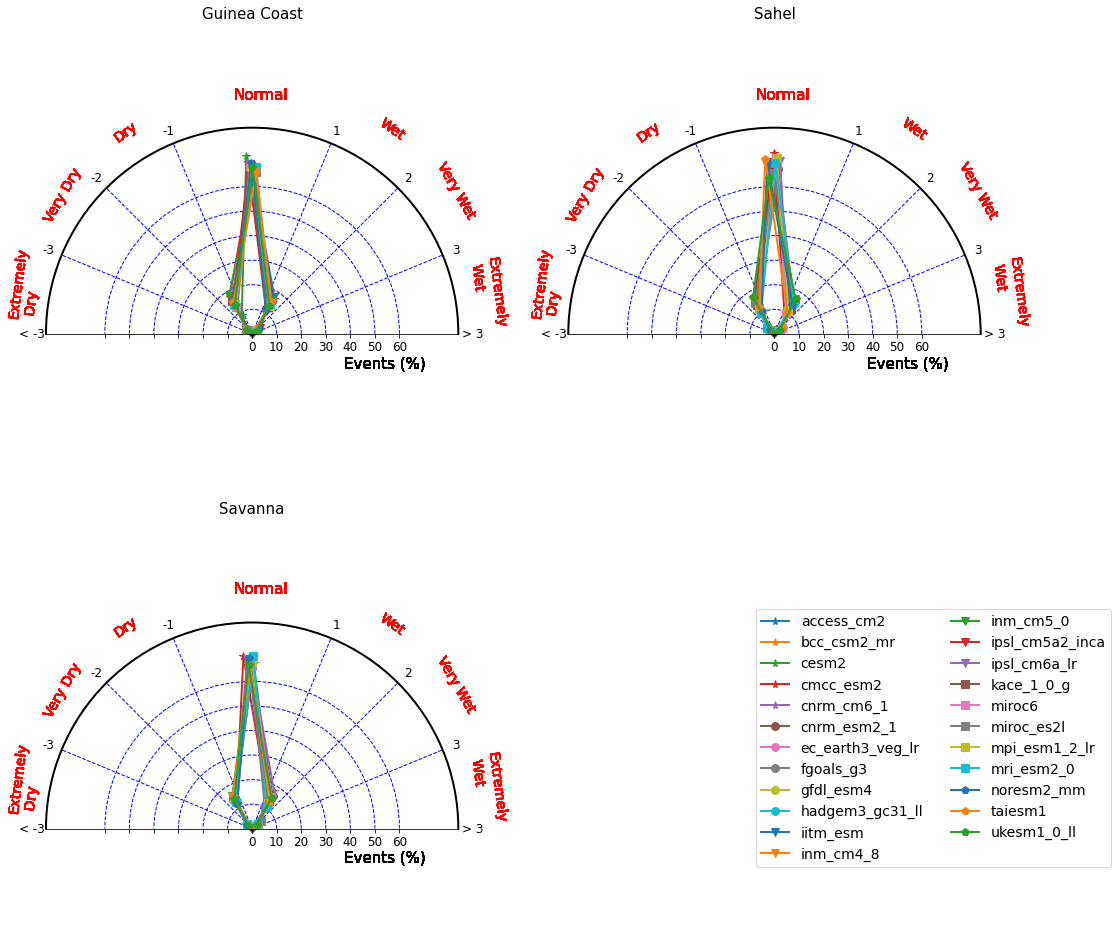

In [8]:
exp='historical'
ystart=1950; yend=2014
classification = ['Extremely Dry', 'Very Dry', 'Dry','Normal', 'Humid', 'Very Humid', 'Extremely Wet']

#plt.figure(figsize = (14,14))

#plt.subplots_adjust(hspace=0.5) 
fig,axes = plt.subplots(2,2,figsize = (14,14),subplot_kw=dict(polar=True))
#plt.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.9, left=0,right=0.95, bottom=0) 
ax = axes.flatten()
zones = ['Guinea Coast','Sahel','Savanna']
for i, mod in enumerate(models):
    file = glob.glob(os.path.join(path,exp+'/*'+mod+'*.zip'))[0]
    data_file = glob.glob(os.path.join(path,mod+'/pr*'+exp+'*.nc'))[0]
    da_data = xr.open_dataset(data_file)
    
    
    percentages={}
    for j,zone in enumerate(zones):
        n_thresh = 3
        a = background(ax[j],zone)
        final_count = {}
        final_avg = {}
        count_val = []
        avg_val = []

        if zone == 'Guinea Coast':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(4,8), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_3 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_3)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            
        elif zone == 'Sahel':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(12,20), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_3 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_3)
            per = (C/max(C.sum(axis = 1)))*100
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
        else:
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(8,12), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_3 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_3)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=True)
fig.delaxes(ax[3])           
   
save_plot('/home/receiver/Desktop/Data/plots/','SPI-3_Polar_plot_extreme_events')

###  SPI-6 Polar plots of extreme events of precipitation for the ecological zones over West Africa

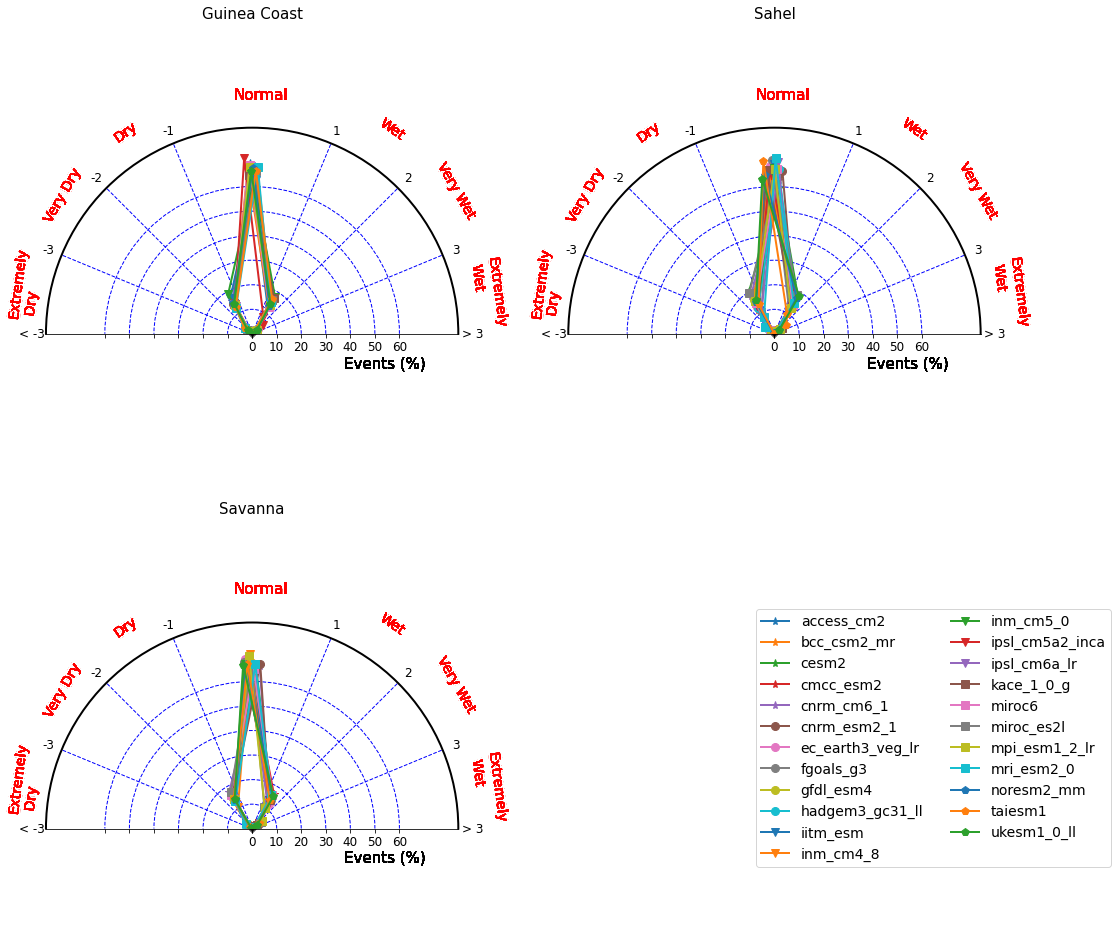

In [10]:
exp='historical'
ystart=1950; yend=2014
classification = ['Extremely Dry', 'Very Dry', 'Dry','Normal', 'Humid', 'Very Humid', 'Extremely Wet']

#plt.figure(figsize = (14,14))

#plt.subplots_adjust(hspace=0.5) 
fig,axes = plt.subplots(2,2,figsize = (14,14),subplot_kw=dict(polar=True))
#plt.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.9, left=0,right=0.95, bottom=0) 
ax = axes.flatten()
zones = ['Guinea Coast','Sahel','Savanna']
for i, mod in enumerate(models):
    file = glob.glob(os.path.join(path,exp+'/*'+mod+'*.zip'))[0]
    data_file = glob.glob(os.path.join(path,mod+'/pr*'+exp+'*.nc'))[0]
    da_data = xr.open_dataset(data_file)
    
    
    percentages={}
    for j,zone in enumerate(zones):
        n_thresh = 6
        a = background(ax[j],zone)
        final_count = {}
        final_avg = {}
        count_val = []
        avg_val = []

        if zone == 'Guinea Coast':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(4,8), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_6 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_6)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            
        elif zone == 'Sahel':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(12,20), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_6 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_6)
            per = (C/max(C.sum(axis = 1)))*100
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
        else:
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(8,12), time=slice(str(ystart),str(yend)))#.mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            sampled_da = da_RR.resample(time='1Y').sum('time')
            spi_6 = spi(sampled_da, n_thresh,'time')[9]
            C,AV = count_avg(spi_6)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = None, marker = markers[i//5], marksize=8, label=mod, show_legend=True)
fig.delaxes(ax[3])           
   
save_plot('/home/receiver/Desktop/Data/plots/','SPI-6_Polar_plot_extreme_events')

### correlations and bias